<a href="https://colab.research.google.com/github/sidagarwal-labs/Analyzing-Yelp-Reviews---Philadelphia-Restaurants/blob/main/XGBoost_Regressor_to_predict_business_overall_stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost
!pip install shap

In [ ]:
import json
import pandas as pd

from google.colab import drive, ai, userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Load data

In [ ]:
business_df = pd.read_parquet("/content/drive/MyDrive/yelp_final_project/yelp_philadelphia/business.parquet")
review_df   = pd.read_parquet("/content/drive/MyDrive/yelp_final_project/yelp_philadelphia/review.parquet")
checkin_df  = pd.read_parquet("/content/drive/MyDrive/yelp_final_project/yelp_philadelphia/checkin.parquet")

## Feature Engineering

### Business-level features from business dataset

In [ ]:
biz = business_df.copy()

# Basic numeric features
biz_features = biz[[
    'business_id', 'stars', 'review_count', 'is_open',
    'latitude', 'longitude'
]].copy()

# Simple “price range” and parking features from attributes if available
def safe_get(d, key):
    try:
        if pd.isna(d):
            return None
        return eval(d).get(key)  # attributes is a stringified dict
    except Exception:
        return None

biz_features['BikeParking'] = biz['attributes'].apply(lambda x: safe_get(x, 'BikeParking'))
biz_features['RestaurantsPriceRange2'] = biz['attributes'].apply(
    lambda x: safe_get(x, 'RestaurantsPriceRange2')
)

# Categories: make a small set of common one-hot features
top_cats = (biz['categories'].dropna()
            .str.get_dummies(sep=', ')
            .sum()
            .sort_values(ascending=False)
            .head(30)               # top 30 categories
            .index)

cat_dummies = biz['categories'].str.get_dummies(sep=', ')[top_cats]
cat_dummies.columns = [f"cat_{c.replace(' ', '_')}" for c in cat_dummies.columns]

biz_features = pd.concat([biz_features, cat_dummies], axis=1)

In [ ]:
biz_features

,business_id,stars,review_count,is_open,latitude,longitude,BikeParking,RestaurantsPriceRange2,cat_Restaurants,cat_Food,...,cat_Specialty_Food,cat_Chicken_Wings,cat_Bakeries,cat_Japanese,cat_Asian_Fusion,cat_Vegetarian,cat_Caterers,cat_Desserts,cat_Sushi_Bars,cat_Mediterranean
0,MTSW4McQd7CbVtyjqoe9mw,4.0,80,1,39.955505,-75.155564,None,None,1,1,...,0,0,1,0,0,0,0,0,0,0
1,MUTTqe8uqyMdBl186RmNeA,4.0,245,1,39.953949,-75.143226,None,None,1,0,...,0,0,0,1,0,0,0,0,1,0
2,ROeacJQwBeh05Rqg7F6TCg,4.5,205,1,39.943223,-75.162568,None,None,1,0,...,0,0,0,0,0,0,0,0,0,0
3,QdN72BWoyFypdGJhhI5r7g,4.0,65,0,39.939825,-75.157447,None,None,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Mjboz24M9NlBeiOJKLEd_Q,3.0,41,0,40.022466,-75.218314,None,None,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,VZbkSeZtFynEascotq7ExA,4.0,8,0,39.953391,-75.196765,None,None,1,0,...,0,0,0,0,0,0,0,0,0,0
5852,gPr1io7ks0Eo3FDsnDTYfg,4.0,21,0,40.060414,-75.191084,None,None,1,0,...,0,0,0,0,0,0,0,0,0,0
5853,wVxXRFf10zTTAs11nr4xeA,3.0,55,1,40.032483,-75.214430,None,None,1,1,...,1,0,0,0,0,0,0,0,0,0
5854,8n93L-ilMAsvwUatarykSg,3.0,22,0,39.951018,-75.198240,None,None,1,1,...,0,0,0,0,0,0,0,0,0,0


### Textual review features per business

Average review length, variance, etc.

In [ ]:
# from textblob import TextBlob

# Review-level features
review_df['text_len'] = review_df['text'].str.len()
review_df['word_count'] = review_df['text'].str.split().str.len()

# review_df['sent_polarity'] = review_df['text'].apply(
#     lambda t: TextBlob(t).sentiment.polarity
# )

# Aggregate to business level
review_agg = review_df.groupby('business_id').agg(
    review_std_stars=('stars', 'std'),
    review_cnt=('review_id', 'count'),
    text_len_mean=('text_len', 'mean'),
    text_len_std=('text_len', 'std'),
    word_count_mean=('word_count', 'mean'),
    # sent_polarity_mean=('sent_polarity', 'mean'),
).reset_index()

In [ ]:
review_agg

,business_id,review_std_stars,review_cnt,text_len_mean,text_len_std,word_count_mean
0,-0M0b-XhtFagyLmsBtOe8w,0.894792,18,862.833333,478.096748,159.277778
1,-0PN_KFPtbnLQZEeb23XiA,1.361817,11,253.090909,117.080703,47.181818
2,-0TffRSXXIlBYVbb5AwfTg,0.983165,1132,653.516784,575.093882,117.558304
3,-0eUa8TsXFFy0FCxHYmrjg,1.070899,28,489.678571,305.275474,90.571429
4,-1B9pP_CrRBJYPICE5WbRA,1.205760,851,593.628672,500.974256,108.880141
...,...,...,...,...,...,...
5851,zxY4DgtXsVHihSUpsmwamg,0.516398,6,288.500000,119.461709,54.000000
5852,zy7uNOvpykrq-XlmDY_wHA,0.983192,6,635.833333,411.092893,114.666667
5853,zyMkbavgHASQtqVwaock9A,0.928388,21,533.047619,391.299307,97.571429
5854,zz-fcqurtm77bZ_rVvo2Lw,0.714143,25,723.280000,427.575970,130.600000


### Check-in features as behavioral signals

We transformed Yelp’s raw check-in timestamps into usable behavioral features.
Each business’s check-in string was parsed into individual timestamps, and from these we computed:
* checkin_cnt: total number of check-ins
* checkin_unique_days: number of distinct days with check-ins
* checkin_span_days: time span between the first and last check-in

These features capture how often and how consistently customers visit a business, providing the model with signals about real customer engagement.

In [ ]:
from datetime import datetime

def parse_checkins(date_str):
    if pd.isna(date_str):
        return []
    return [datetime.strptime(d.strip(), "%Y-%m-%d %H:%M:%S")
            for d in date_str.split(',') if d.strip()]

def summarize_checkins(date_str):
    times = parse_checkins(date_str)
    if not times:
        return pd.Series({
            'checkin_cnt': 0,
            'checkin_unique_days': 0,
            'checkin_span_days': 0
        })
    times_sorted = sorted(times)
    days = {t.date() for t in times}
    span = (times_sorted[-1] - times_sorted[0]).days or 1
    return pd.Series({
        'checkin_cnt': len(times),
        'checkin_unique_days': len(days),
        'checkin_span_days': span
    })

checkin_features = (checkin_df
    .set_index('business_id')['date']
    .apply(summarize_checkins)
    .reset_index())

In [ ]:
checkin_features

,business_id,checkin_cnt,checkin_unique_days,checkin_span_days
0,-0M0b-XhtFagyLmsBtOe8w,57,55,2122
1,-0PN_KFPtbnLQZEeb23XiA,15,15,1174
2,-0TffRSXXIlBYVbb5AwfTg,1495,1025,3151
3,-0eUa8TsXFFy0FCxHYmrjg,33,32,1352
4,-1B9pP_CrRBJYPICE5WbRA,3552,1819,3463
...,...,...,...,...
5651,zxRmQ_FWVowh8rlzLCSURQ,16,16,2667
5652,zxY4DgtXsVHihSUpsmwamg,4,4,988
5653,zyMkbavgHASQtqVwaock9A,69,68,1485
5654,zz-fcqurtm77bZ_rVvo2Lw,44,42,958


### New vs. Established businesses

In [ ]:
age_df = (review_df
          .groupby('business_id')['date']
          .agg(['min', 'max'])
          .reset_index())
age_df['age_days'] = (age_df['max'] - age_df['min']).dt.days

In [ ]:
age_df

,business_id,min,max,age_days
0,-0M0b-XhtFagyLmsBtOe8w,2012-02-10 04:00:49,2018-05-13 04:00:27,2283
1,-0PN_KFPtbnLQZEeb23XiA,2009-10-16 15:24:48,2016-04-15 21:44:07,2373
2,-0TffRSXXIlBYVbb5AwfTg,2013-06-01 01:47:50,2022-01-18 18:56:27,3153
3,-0eUa8TsXFFy0FCxHYmrjg,2015-10-20 18:20:03,2019-09-14 17:35:02,1424
4,-1B9pP_CrRBJYPICE5WbRA,2012-07-18 02:37:42,2022-01-16 19:38:30,3469
...,...,...,...,...
5851,zxY4DgtXsVHihSUpsmwamg,2012-05-06 22:52:29,2019-10-02 02:55:18,2704
5852,zy7uNOvpykrq-XlmDY_wHA,2008-01-19 20:59:57,2009-06-08 22:26:57,506
5853,zyMkbavgHASQtqVwaock9A,2010-05-08 16:38:03,2015-02-09 16:10:42,1737
5854,zz-fcqurtm77bZ_rVvo2Lw,2011-11-17 17:08:56,2013-09-30 04:29:21,682


## Combine everything and prepare for XGBoost

In [ ]:
from functools import reduce

df_list = [biz_features, review_agg, checkin_features]
full_df = reduce(lambda left, right: pd.merge(left, right, on='business_id', how='left'), df_list)
full_df = full_df.merge(age_df[['business_id', 'age_days']], on='business_id', how='left')

full_df['age_group'] = pd.cut(
    full_df['age_days'],
    bins=[-1, 365, 3*365, 100*365],
    labels=['new', 'mid', 'established']
).cat.codes

# Fill NA for numeric features
num_cols = full_df.select_dtypes(include=['number', 'bool']).columns.drop(['stars','age_days'])
full_df[num_cols] = full_df[num_cols].fillna(0)

X = full_df[num_cols]             # features
y = full_df['stars']              # target business rating


In [ ]:
X

,review_count,is_open,latitude,longitude,cat_Restaurants,cat_Food,cat_Nightlife,cat_Bars,cat_Sandwiches,cat_Pizza,...,cat_Mediterranean,review_std_stars,review_cnt,text_len_mean,text_len_std,word_count_mean,checkin_cnt,checkin_unique_days,checkin_span_days,age_group
0,80,1,39.955505,-75.155564,1,1,0,0,0,0,...,0,1.113932,87,558.919540,428.767222,104.620690,335.0,306.0,4119.0,2
1,245,1,39.953949,-75.143226,1,0,0,0,0,0,...,0,1.165088,250,647.640000,551.181774,118.448000,172.0,150.0,1488.0,2
2,205,1,39.943223,-75.162568,1,0,0,0,0,0,...,0,0.945515,208,432.432692,301.254054,79.451923,221.0,200.0,2899.0,2
3,65,0,39.939825,-75.157447,1,0,1,1,0,0,...,0,1.345321,69,514.275362,430.958674,93.681159,81.0,66.0,1220.0,2
4,41,0,40.022466,-75.218314,1,0,0,0,0,1,...,0,1.777913,41,470.146341,395.368282,88.097561,9.0,7.0,1177.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,8,0,39.953391,-75.196765,1,0,0,0,0,0,...,0,1.054093,9,583.888889,384.998196,107.888889,11.0,11.0,585.0,1
5852,21,0,40.060414,-75.191084,1,0,0,0,1,0,...,0,1.214095,22,350.545455,233.740338,63.000000,12.0,12.0,1095.0,2
5853,55,1,40.032483,-75.214430,1,1,0,0,1,0,...,0,1.387512,59,505.610169,344.021752,92.847458,64.0,63.0,4114.0,2
5854,22,0,39.951018,-75.198240,1,1,0,0,1,0,...,0,1.258736,22,649.272727,394.109869,119.500000,46.0,45.0,2014.0,2


In [ ]:
full_df.columns

Index(['business_id', 'stars', 'review_count', 'is_open', 'latitude',
       'longitude', 'BikeParking', 'RestaurantsPriceRange2', 'cat_Restaurants',
       'cat_Food', 'cat_Nightlife', 'cat_Bars', 'cat_Sandwiches', 'cat_Pizza',
       'cat_American_(New)', 'cat_Breakfast_&_Brunch',
       'cat_American_(Traditional)', 'cat_Coffee_&_Tea', 'cat_Italian',
       'cat_Chinese', 'cat_Fast_Food', 'cat_Burgers', 'cat_Seafood',
       'cat_Cafes', 'cat_Mexican', 'cat_Delis',
       'cat_Event_Planning_&_Services', 'cat_Salad', 'cat_Specialty_Food',
       'cat_Chicken_Wings', 'cat_Bakeries', 'cat_Japanese', 'cat_Asian_Fusion',
       'cat_Vegetarian', 'cat_Caterers', 'cat_Desserts', 'cat_Sushi_Bars',
       'cat_Mediterranean', 'review_std_stars', 'review_cnt', 'text_len_mean',
       'text_len_std', 'word_count_mean', 'checkin_cnt', 'checkin_unique_days',
       'checkin_span_days', 'age_days', 'age_group'],
      dtype='object')

**Data Preparation Methods:**  
We used three components of the Yelp Open Dataset: business data, review data, and check-in data. These tables were merged to create a single business-level dataset for prediction. Business data provided static attributes such as categories, review count, location, and selected fields extracted from the attributes dictionary. Review data was aggregated to the business level to create textual and behavioral features, including average review length, word count, sentiment scores, and the variation in star ratings. These features were produced by applying summary statistics such as mean, standard deviation, and count across all reviews associated with each business. Check-in data was parsed into timestamps and summarized to produce total check-ins, the number of unique check-in days, and the span of check-in activity, which served as indicators of customer engagement.

All tables were merged using the business_id key, and missing numeric values were filled with zero to ensure compatibility with the model. The final dataset contained structured business attributes, aggregated review text features, and behavioral signals from check-in activity, forming the feature matrix used for model training and evaluation.

# Model Training & Evaluation

## Train an XGBoost regressor

XGBoost Regressor is a model that predicts numeric values by building many small decision trees, with each one learning from the mistakes of the last.  

       
  
**Model Training Methods:**   
We framed the problem as a regression task, using the business star rating from the Yelp dataset as the target variable. All engineered features from preprocessing were combined into a single feature matrix, including business attributes, category indicators, aggregated review text features, and check-in metrics. Because XGBoost handles different feature scales well, no additional normalization or standardization was applied.

The data was split into training and test sets using an 80/20 split with a fixed random seed to keep the results reproducible. We selected XGBoost as the modeling approach because it performs well on structured datasets, handles nonlinear relationships, and can learn from a large number of engineered features without heavy preprocessing. The model was trained using a squared-error objective, with key hyperparameters such as the number of trees, depth, learning rate, and sampling ratios tuned to balance flexibility and generalization. XGBoost trains sequentially, with each tree learning to correct the remaining errors from the previous trees.

After training, we generated predictions on the test set and evaluated performance using RMSE and R². We also used SHAP values to interpret the model and understand which features had the strongest influence on the predicted ratings.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R^2: {r2:.3f}")

RMSE: 0.540, R^2: 0.521


## Examine residuals

Residual = actual – predicted  

Patterns in residuals tell you where the model struggles

### Plot residual distribution

<Axes: xlabel='stars', ylabel='Count'>

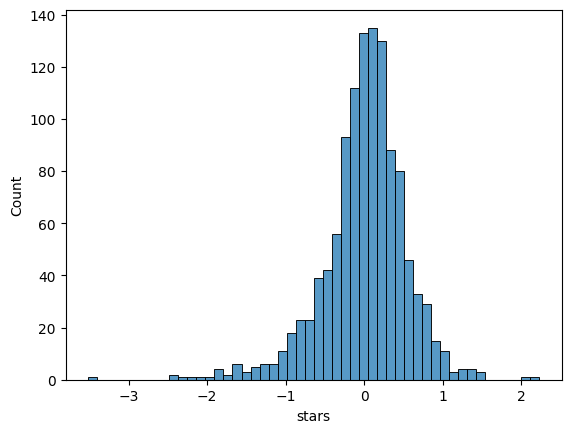

In [ ]:
import seaborn as sns
sns.histplot(y_test - y_pred, bins=50)

Residuals are centered near zero with most predictions within one star, indicating reasonable accuracy, with a few businesses acting as outliers.

### Scatter residuals vs predictions

<Axes: ylabel='stars'>

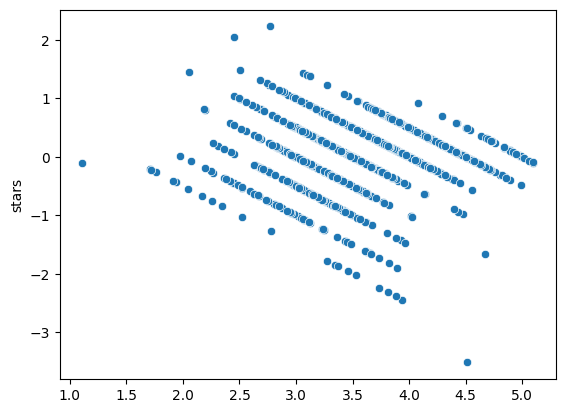

In [ ]:
sns.scatterplot(x=y_pred, y=y_test - y_pred)

The diagonal pattern (banded residual lines) appears because Yelp ratings are discrete (1–5), but predictions are continuous, so each true rating produces horizontal stripes.

## Examine feature importance

### Split Frequency

This shows how often a feature was used to split decision trees, averaged across trees.

*"How often did the model use this feature in splits?"*

In [ ]:
imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp.head(20))

cat_Fast_Food                 0.291262
cat_Burgers                   0.062244
review_std_stars              0.050285
cat_Pizza                     0.044107
cat_Chicken_Wings             0.043420
age_group                     0.043061
review_cnt                    0.029017
cat_Coffee_&_Tea              0.021276
cat_Caterers                  0.021116
word_count_mean               0.020900
cat_Sushi_Bars                0.017224
checkin_span_days             0.017025
checkin_cnt                   0.015977
cat_American_(Traditional)    0.015937
is_open                       0.015796
cat_Food                      0.015347
cat_Japanese                  0.015312
cat_Vegetarian                0.015286
cat_Bakeries                  0.014898
cat_Italian                   0.013091
dtype: float32


### Feature Importance with SHAP

XGBoost’s built-in feature importance values measure how often a feature was used to split a tree, not how much it influenced the predictions. SHAP values instead measure each feature’s actual impact on the model’s output. Because of this, SHAP gives a more accurate view of feature importance.

In [ ]:
import shap
import numpy as np

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

**Summary Plot (high-level global importance)**

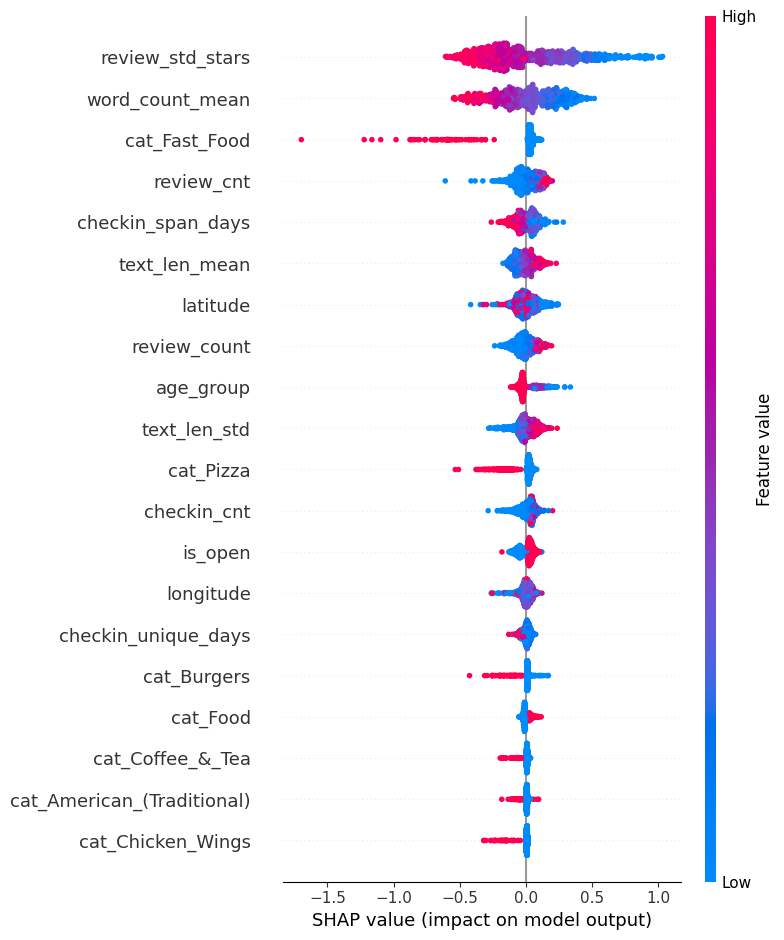

In [ ]:
shap.summary_plot(shap_values, X_test)

This shows:
* most influential features (top to bottom)
* direction and magnitude of SHAP impact (color = feature value)

**Bar Plot (feature importance)**

*"How much does each feature actually change the predictions, on average?"*

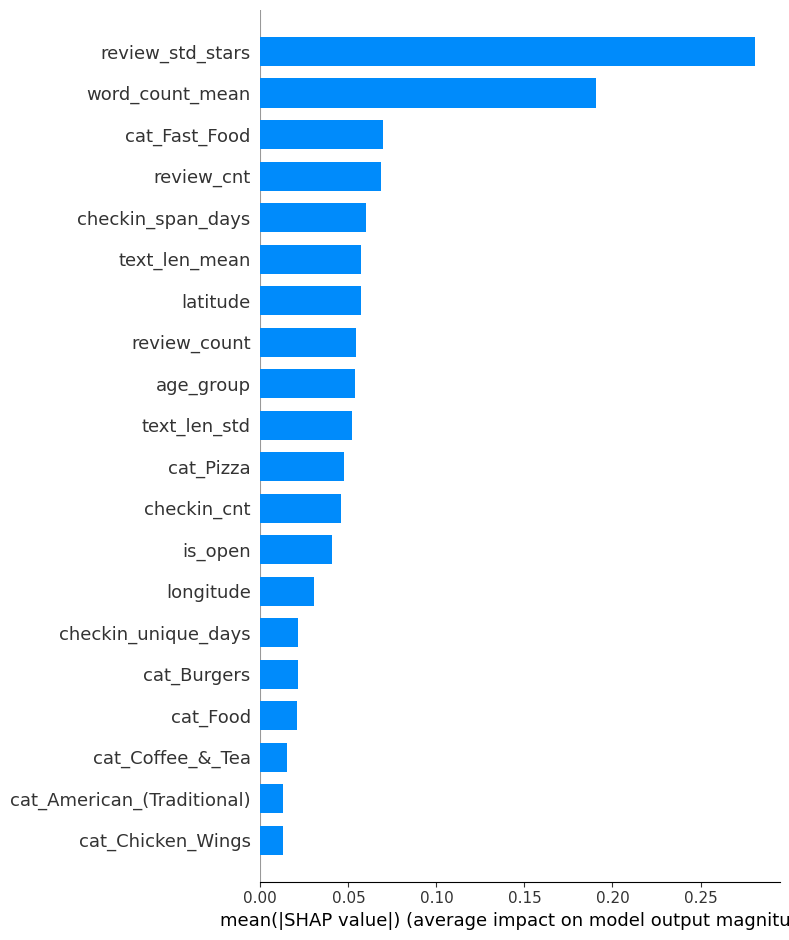

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

**Single-business explanation (local SHAP)**

In [ ]:
shap.initjs()
idx = 0 # Define idx, for example, to explain the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values[idx], X_test.iloc[idx])

This shows:
* Which features push the prediction up
* Which features push it down
* Why this specific business gets the predicted star rating



---


# Evaluating new vs. established businesses
**Age_Group**:  
0 = new  
1 = mid  
2 = established  

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

eval_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'age_group': X_test['age_group']
})

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

for g in sorted(eval_df['age_group'].unique()):
    sub = eval_df[eval_df['age_group'] == g]
    print(
        f"Age group {g}: RMSE = {rmse(sub.y_true, sub.y_pred):.3f},  n = {len(sub)}"
    )

Age group 0: RMSE = 0.683,  n = 100
Age group 1: RMSE = 0.532,  n = 225
Age group 2: RMSE = 0.522,  n = 847


The model performs worse on new businesses and better on established ones. New businesses show much higher prediction error (RMSE ≈ 0.68) compared to mid-age businesses (RMSE ≈ 0.53) and established businesses (RMSE ≈ 0.52). This indicates that established businesses are easier to predict, likely because they accumulate more reviews and richer behavioral signals such as check-ins.  

Additionally, SHAP analysis confirms that business age influences how much weight the model places on review-related features. Established businesses benefit from consistent sentiment, word-count patterns, and stable variance in star ratings, while new businesses show weaker or unreliable signals.